<a href="https://colab.research.google.com/github/sorawit27/Stock-Forecast/blob/master/Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading
In this project, we will look at a total of nine different stock indices from different demographics, and use LSTM to try to predict its future prices. In addition, we will try to implement a simple trading algorithm based on the predictions and see how well it does compared to a random trading model or just holding stocks without selling them.

For best viewing experience and to get the correct formattings, if you're on GitHub, please open this Python notebook in Google Colab. Link should be on the very top of the page.

We start by checking that all libraries are added and are of appropriate versions

In [ ]:
# Python ≥3.5 is requiredw
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation

from keras.regularizers import L1L2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path
!pip install chart_studio
import plotly.express as px

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install data reader to read stock data from Yahoo Finance
!pip install pandas_datareader
from pandas_datareader import data as pdr

Now we import historical stock data from Yahoo Finance for three major banks in Thailand: Kasikorn Bank, Siam Commercial Bank, Bangkok Bank; the Airport of Thailand; S&P 500 Index; NASDAQ Index; Apple; Amazon; Microsoft; Alphabet; Tesla; and Johnson & Johnson to represent a wide variety of sectors to see the effects of COVID-19 different in each.

Note that this project has been implemented using stock prices during the COVID-19 crisis, up until 10 October 2020, just before the 2020 US Presidential Election.

In [ ]:
stock_names = ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','NDAQ', 'AAPL','AMZN','MSFT','GOOG','TSLA', 'JNJ']
stock_data = []

for name in stock_names:
    try:
        data = pd.DataFrame(pdr.get_data_yahoo(name, start='2005-01-01', end='2020-10-10'))
        stock_data.append(data)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

Let's take a look at a sample stock: this table below is for the SP500 index.

In [ ]:
stock_data[4].head()

High         Low  ...      Volume  Adj Close
Date                                ...                       
2005-01-03  121.760002  119.900002  ...  55748000.0  87.794243
2005-01-04  120.540001  118.440002  ...  69167600.0  86.721436
2005-01-05  119.250000  118.000000  ...  65667300.0  86.123009
2005-01-06  119.150002  118.260002  ...  47814700.0  86.560890
2005-01-07  119.230003  118.129997  ...  55847700.0  86.436821

[5 rows x 6 columns]

Now we look at all the all the stocks, but only at their adjusted closing price to account for stock splits, dividends, etc.

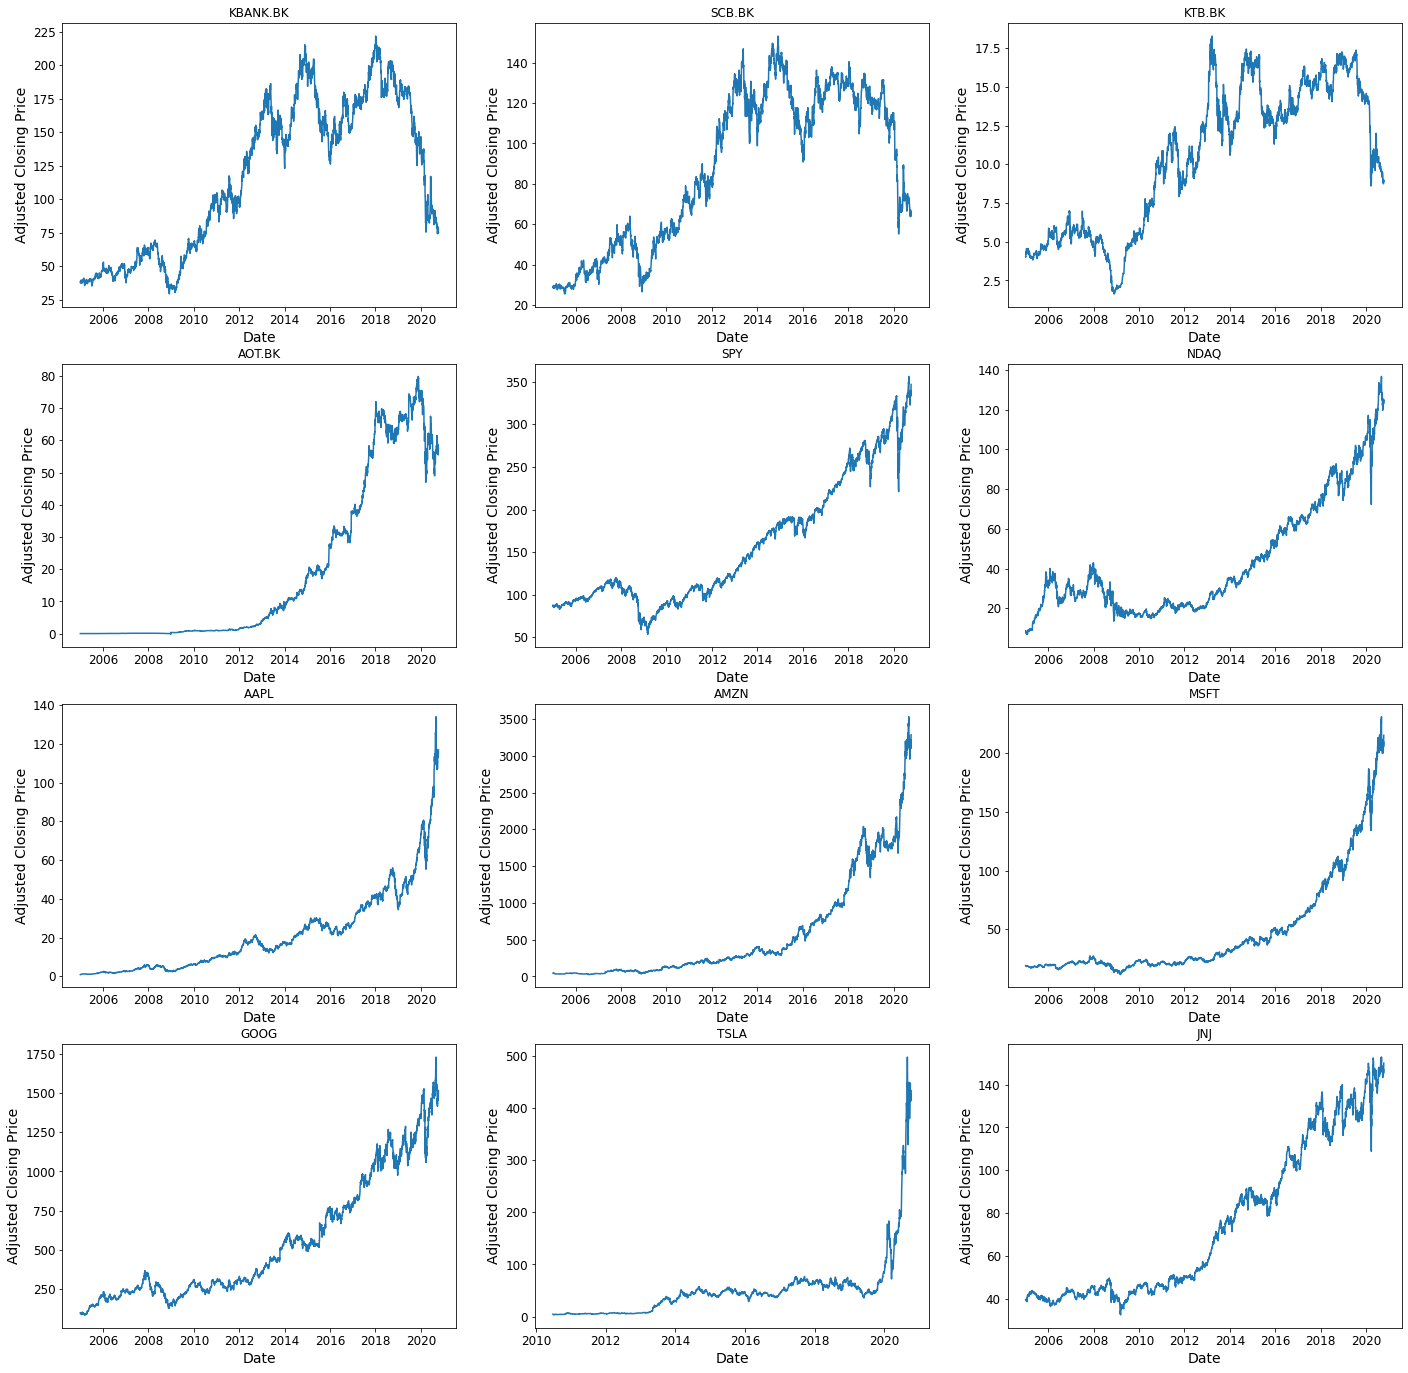

In [ ]:
fig, axs = plt.subplots(4,3, figsize=(24,24))
axs = axs.ravel()

# plot adjusted closing price of all stocks
i = 0
for stock in stock_data:
  axs[i].plot(stock.index, stock["Adj Close"])
  axs[i].set_xlabel('Date')
  axs[i].set_ylabel('Adjusted Closing Price')
  axs[i].set_title(stock_names[i])
  i = i+1

# Stock Price Prediction
Now we choose which stock we want to predict:

In [ ]:
stock_chosen = 'AOT.BK' #@param ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','NDAQ', 'AAPL','AMZN','MSFT','GOOG','TSLA', 'JNJ']

In [ ]:
index = stock_names.index(stock_chosen)
print(index)

3


In [ ]:
len = (stock_data[index].shape)[0]
print(len)

3872


Next, we split the data into 3 sets - training, validation, and testing

In [ ]:
# spit data into train/valid/test data (70/20/10)
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2710, 1)
(774, 1)
(388, 1)


Now we scale the data to optimize the performance of our neural network:
Important: Note that in this example, we are trying to predict stock prices with the lag of 5, i.e. using prices 5 days ago to predict today's based on historical trends 

In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 3 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(2650, 55)
(2650,)
(714, 55)
(714,)
(328, 55)
(2650, 55, 1)
(2650,)
(714, 55, 1)
(714,)
(328, 55, 1)


Now we will start constructing our neural network: normally stock data is predicted using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) which has proved to be advantageous in predicting gularization since they assemble "more complex patterns using smaller and simpler patterns", which is reminiscent of stock data, and use less pre-processing compared to other algorithms.

However, we will also be using Long Short-Term Memories (LSTMs), a type of RNN that can retain information over long peroids of time, while forgetting irrevelant information as the time gap grows. This is useful for analyzing time series.

For more information, see [here](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

Possible future implementations will attempt to use other types of neural networks or machine learning algorithms (e.g. RNNs with more hyperparameter tuning) that can more accurately predict these prices, and perhaps with a more sophisticated trading algorithm than simple buy and sell orders.

We start building our neural network full of LSTM layers with some dropout and one convolutional layer at the very beginning.

Training Model from Scratch
Epoch 1/100
133/133 [==============================] - 4s 27ms/step - loss: 0.0346 - mse: 0.0346 - mae: 0.1226 - mape: 70.4509 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.1077 - val_mape: 26.8802
Epoch 2/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0802 - mape: 45.5619 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0540 - val_mape: 16.3087
Epoch 3/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0744 - mape: 45.8895 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0606 - val_mape: 14.2647
Epoch 4/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0718 - mape: 48.9923 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0571 - val_mape: 13.4928
Epoch 5/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0733 - mape: 50.6075 - val_loss: 0.0066 - val_mse: 0.0066 

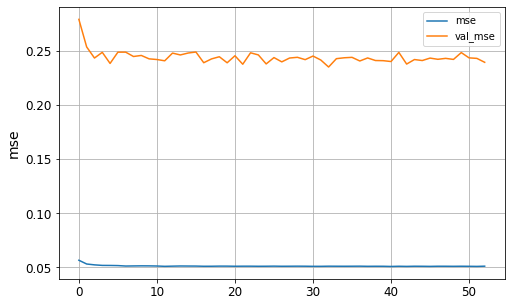

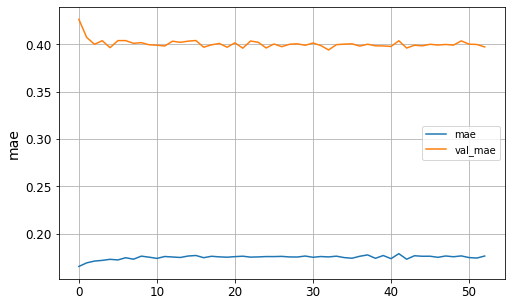

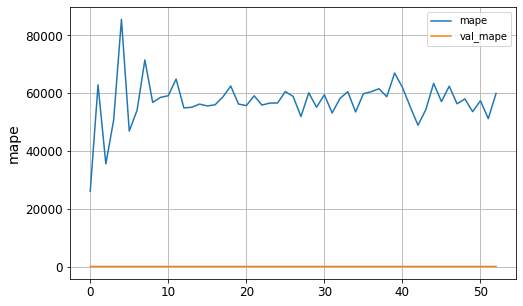

In [ ]:
def create_model(dropout_rate=0.3, lstm_unit=20, conv_unit=5, lstm_layers=2, optimizer='adam'):
    model = Sequential()
    # Adding CNN layers to model of kernel_size(length) = 5
    model.add(Conv1D(1, conv_unit, activation='relu'))
    # Adding LSTM layers with Dropout
    model.add(LSTM(units = lstm_unit, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))

    for l in range(lstm_layers):                                 
        model.add(LSTM(units = lstm_unit, return_sequences = True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units = lstm_unit))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape']) 
    return model

# checkpoint so we can resume training model if traning was interrupted 
checkpoint_cb = keras.callbacks.ModelCheckpoint("grid_model_extra.h5", save_best_only=True)

"""
try:
    model = keras.models.load_model("grid_model_extra.h5") 
    print("Continue Training Model")
except:
    print("Training Model from Scratch")
"""

# initial hyperparameters for tuning
lstm_layers= [2, 5 ,10]
conv_unit = [5, 10, 20]
batch_size = [10, 40, 100]
dropout_rate = [0.6, 0.5, 0.7]
lstm_unit = [20, 50]
epochs = [100]
optimizer = ['adam']
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 

model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model) 
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer)
# param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer, conv_unit=conv_unit, lstm_layers=lstm_layers, lstm_unit=lstm_unit)

random = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
random_result = random.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=early_stopping)

# save current model as a h5 file
random_result.best_estimator_.model.save("grid_model_extra.h5")

# plot performance of our model based on all three metrics
pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mse", "val_mse"]}).plot(figsize=(8, 5)) 
plt.grid(True)
plt.ylabel("mse")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mae", "val_mae"]}).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel("mae")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mape", "val_mape"]}).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel("mape")
plt.show()

Now let's see if we can reduce the errors by adding in regularizers in the hyperparameter tuning process, since our model is overfitting, evident from the errors of validation set being a bit higher than that of the training set:


Epoch 1/100
14/14 [==============================] - 1s 103ms/step - loss: 0.2983 - mse: 0.0984 - mae: 0.2286 - mape: 98.5825 - val_loss: 0.2734 - val_mse: 0.0746 - val_mae: 0.2405 - val_mape: 74.4901
Epoch 2/100
14/14 [==============================] - 0s 19ms/step - loss: 0.2389 - mse: 0.0417 - mae: 0.1629 - mape: 150.2756 - val_loss: 0.2125 - val_mse: 0.0172 - val_mae: 0.1118 - val_mape: 30.4769
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 0.2094 - mse: 0.0153 - mae: 0.0830 - mape: 49.9096 - val_loss: 0.1983 - val_mse: 0.0056 - val_mae: 0.0580 - val_mape: 17.7284
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 0.2061 - mse: 0.0148 - mae: 0.0831 - mape: 45.8672 - val_loss: 0.1939 - val_mse: 0.0044 - val_mae: 0.0540 - val_mape: 19.1420
Epoch 5/100
14/14 [==============================] - 0s 20ms/step - loss: 0.2022 - mse: 0.0139 - mae: 0.0767 - mape: 41.7930 - val_loss: 0.1895 - val_mse: 0.0028 - val_mae: 0.0385 - val_mape: 12.146

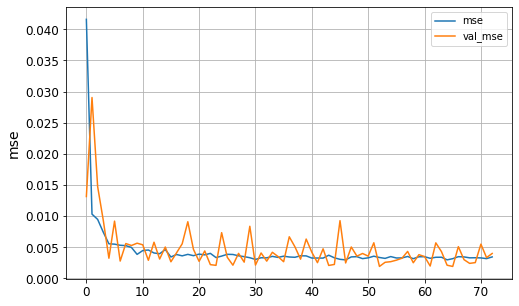

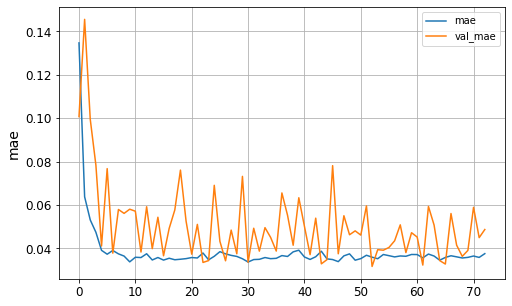

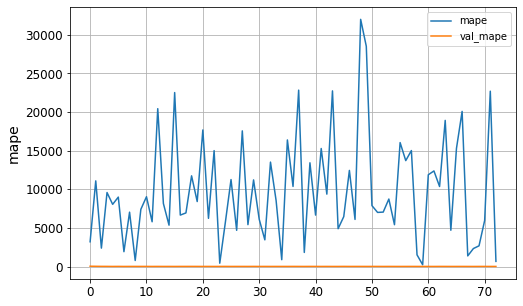

In [ ]:
def create_model(dropout_rate=0.3, lstm_unit=20, conv_unit=5, lstm_layers=2, optimizer='adam', regularizers=L1L2(l1=0.01, l2=0.00)):
    model = Sequential()
    # Adding CNN layers to model of kernel_size(length) = 5
    model.add(Conv1D(1, conv_unit, activation='relu', bias_regularizer=regularizers))
    # Adding LSTM layers with Dropout
    model.add(LSTM(units = lstm_unit, return_sequences = True, input_shape = (X_train.shape[1], 1), bias_regularizer=regularizers))
    model.add(Dropout(dropout_rate))

    for l in range(lstm_layers):                                 
        model.add(LSTM(units = lstm_unit, return_sequences = True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units = lstm_unit))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape']) 
    return model

# checkpoint so we can resume training model if traning was interrupted 
checkpoint_cb = keras.callbacks.ModelCheckpoint("grid_model_extra_reg.h5", save_best_only=True)

"""
try:
    model = keras.models.load_model("grid_model_extra_reg.h5")  
    print("Continue Training Model")
except:
    print("Training Model from Scratch")
"""

# initial hyperparameters for tuning
lstm_layers= [2]
conv_unit = [5]
batch_size = [100]
dropout_rate = [0.5]
lstm_unit = [20]
epochs = [100]
regularizers = [L1L2(l1=0.01, l2=0.01), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.00, l2=0.00)]
optimizer = ['adam']
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 

model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model) 
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer, conv_unit=conv_unit, lstm_layers=lstm_layers, lstm_unit=lstm_unit)
# param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer, conv_unit=conv_unit, lstm_layers=lstm_layers, lstm_unit=lstm_unit, regularizers=regularizers)
random = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
random_result = random.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=early_stopping)

# save current model as a h5 file
random_result.best_estimator_.model.save("grid_model_extra_reg.h5")

# plot performance of our model based on all three metrics
pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mse", "val_mse"]}).plot(figsize=(8, 5))   
plt.grid(True)
plt.ylabel("mse")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mae", "val_mae"]}).plot(figsize=(8, 5))  
plt.grid(True)
plt.ylabel("mae")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mape", "val_mape"]}).plot(figsize=(8, 5)) 
plt.grid(True)
plt.ylabel("mape")
plt.show()

The model did better! Let's revisit the parameters of our latest model:

In [ ]:
model = random_result.best_estimator_.model
print(random_result.best_params_)

{'batch_size': 100, 'conv_unit': 5, 'dropout_rate': 0.5, 'epochs': 100, 'lstm_layers': 2, 'lstm_unit': 20, 'optimizer': 'adam'}


Now we scale the remaining data (the ones we're going to predict)

In [ ]:
dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

and predict the our test data set, which is the last 10 percent our data, and scale it back to its original values

In [ ]:
y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

Finally, we plot our predictions versus actual historical data

In [ ]:
# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

As you can see, the model predicted prices quite accurately, but again, note that we are using a time lag of only 5 days. If this needs to be changed, it can easily be done above [in this cell](https://colab.research.google.com/drive/1m5iw_wvI3c2Ch-QofYmBrHegiO4JKHtd?authuser=1#scrollTo=fWXHcQQMkKAI&line=18&uniqifier=1) (i.e. when appending training,validating,testing data to all X's and y's
```
# This is formatted as code
X_train.append(train_data_scaled[i-50:i, 0])
y_train.append(train_data_scaled[i, 0])
```
This would make the lag 10 days instead of 5.

   



Now we introduce a metric to measure the performance of our model, first we have the usual mean squared error

In [ ]:
mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

MSE: 19.109053260604924
Scaled MSE: 0.9214906577384702


# Simple Trading Algorithm
And now we'll look at the PnL had we had \$100,000 in 
cash plus \$100,000 in stocks at the beggining of our prediction, and use all our cash at hand to buy the stock if it rises by 3%, and short sell it if the price drops by 3%.

In [ ]:
def trading_algo(index, y_test):

  valid_split = int(stock_data[index].shape[0] * 0.9)
  # set up initial cash
  cash = 100000

  # set up initial stock
  most_recent_transaction_price = stock_data[index]['Adj Close'][valid_split+60]
  print("\n*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***")
  print("We start when the stock price is: ${:,.2f}".format(most_recent_transaction_price))
  stock_units = 100000 / most_recent_transaction_price
  initial_stock = stock_units
  print("Total Cash on Hand: ${:,.2f}".format(100000))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)\n".format(stock_units * most_recent_transaction_price, stock_units, most_recent_transaction_price))

  df = pd.DataFrame(columns = ['Order', 'Date', 'Price', '# of stocks']) 

  for i in range(y_test.size):

    # if price rises more than 3 percent from last transction price then buy using all our cash, if no cash left then do nothing
    if(y_test[i] / most_recent_transaction_price >= 1.03 and cash != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      transaction_units = cash / current_price
      # add order to dataframe
      new_row = {'Order':'Buy', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(transaction_units)}
      df = df.append(new_row, ignore_index=True)
      stock_units = stock_units + transaction_units
      cash = 0
      most_recent_transaction_price = current_price

    # if price drops more than 3 percent from last transction price then sell all remaining stocks into cash, if everything is already sold then do nothing
    elif(y_test[i] / most_recent_transaction_price <= 0.97 and stock_units != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      # add order to dataframe
      new_row = {'Order':'Sell', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(stock_units)}
      df = df.append(new_row, ignore_index=True)
      cash = cash + stock_units * current_price
      stock_units = 0
      most_recent_transaction_price = current_price

  # print list of all orders
  display(df)

  final_stock_price = stock_data[index]['Adj Close'][-1]
  print("\nTotal Cash on Hand: ${:,.2f}".format(cash))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)".format(stock_units * final_stock_price, stock_units, final_stock_price))
  print("Total Profit: ${:,.2f} over {} days".format(cash + (stock_units * final_stock_price) - 200000, y_test.size))

  print("\n*** Had we held to stock without selling: ***")
  print("Total Cash on Hand: ${:,.2f}".format(100000))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)".format(initial_stock * final_stock_price, initial_stock, final_stock_price))
  print("Total Profit: ${:,.2f} over {} days".format(100000 + (initial_stock * final_stock_price) - 200000, y_test.size))

index = 3 # AOT  
trading_algo(index, y_test)


*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $65.32
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,531.0120 units worth $65.32 each)



Order       Date   Price # of stocks
0   Buy 2019-06-28  $72.46  1,379.9938
1  Sell 2019-07-01  $73.20  2,911.0057


Total Cash on Hand: $213,095.87
Total Stock on Hand: $0.00 (0.0000 units worth $57.50 each)
Total Profit: $13,095.87 over 328 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $88,033.19 (1,531.0120 units worth $57.50 each)
Total Profit: $-11,966.81 over 328 days


Nnow we're going to look at buying and selling randomly - each day we have a 50/50 chance of buying with all the money we have, or selling all the stocks we have

In [ ]:
import random 

def random_algo(index, y_test):
    
  # set up initial cash
  cash = 100000

  # set up initial stock
  print("\n*** This is a random model - there's a 50/50 chance of buying or selling every single day ***\n")
  stock_units = 100000 / stock_data[index]['Adj Close'][valid_split+60]
  initial_stock = stock_units

  df = pd.DataFrame(columns = ['Order', 'Date', 'Price', '# of stocks']) 

  for i in range(y_test.size):
    # randomize whether buying or selling; 0 is buy and 1 is sell
    decider = random.randint(0,1)

    # if randomly buy
    if(decider == 0 and cash != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      transaction_units = cash / current_price
      # add order to dataframe
      new_row = {'Order':'Buy', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(transaction_units)}
      df = df.append(new_row, ignore_index=True)
      stock_units = stock_units + transaction_units
      cash = 0

    # if randomly sell
    elif(decider == 1 and stock_units != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      # add order to dataframe
      new_row = {'Order':'Sell', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(stock_units)}
      df = df.append(new_row, ignore_index=True)
      cash = cash + stock_units * current_price
      stock_units = 0

  # print list of all orders
  display(df)

  final_stock_price = stock_data[index]['Adj Close'][-1]
  print("\nTotal Cash on Hand: ${:,.2f}".format(cash))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)".format(stock_units * final_stock_price, stock_units, final_stock_price))
  print("Total Profit: ${:,.2f} over {} days".format(cash + (stock_units * final_stock_price) - 200000, y_test.size))

random_algo(index, y_test)


*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date   Price # of stocks
0     Buy 2019-06-11  $65.32  1,531.0120
1    Sell 2019-06-14  $65.81  3,062.0239
2     Buy 2019-06-17  $65.56  3,073.5352
3    Sell 2019-06-19  $72.71  3,073.5352
4     Buy 2019-06-20  $73.20  3,052.8381
..    ...        ...     ...         ...
175  Sell 2020-10-01  $56.50  2,574.8213
176   Buy 2020-10-05  $56.25  2,586.2649
177  Sell 2020-10-06  $55.50  2,586.2649
178   Buy 2020-10-07  $57.25  2,507.2088
179  Sell 2020-10-08  $57.25  2,507.2088

[180 rows x 4 columns]


Total Cash on Hand: $143,537.70
Total Stock on Hand: $0.00 (0.0000 units worth $57.50 each)
Total Profit: $-56,462.30 over 328 days


Now let's use the **same** model to predict stocks in the other sectors.

In [ ]:
#@title KBank
index = 0 # KBANK

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 117.6601489547957
Scaled MSE: 1.3317376704899038

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $183.76
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (544.1935 units worth $183.76 each)



Order       Date    Price # of stocks
0  Sell 2019-06-11  $183.76    544.1935


Total Cash on Hand: $200,000.00
Total Stock on Hand: $0.00 (0.0000 units worth $75.25 each)
Total Profit: $0.00 over 328 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $40,950.56 (544.1935 units worth $75.25 each)
Total Profit: $-59,049.44 over 328 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date    Price # of stocks
0     Buy 2019-06-11  $183.76    544.1935
1    Sell 2019-06-12  $184.23  1,088.3870
2     Buy 2019-06-13  $184.23  1,088.3870
3    Sell 2019-06-17  $182.33  1,088.3870
4     Buy 2019-06-18  $180.90  1,096.9796
..    ...        ...      ...         ...
162   Buy 2020-09-28   $79.50  2,543.1034
163  Sell 2020-09-29   $78.00  2,543.1034
164   Buy 2020-09-30   $77.00  2,576.1307
165  Sell 2020-10-02   $75.75  2,576.1307
166   Buy 2020-10-06   $75.00  2,601.8920

[167 rows x 4 columns]


Total Cash on Hand: $0.00
Total Stock on Hand: $195,792.37 (2,601.8920 units worth $75.25 each)
Total Profit: $-4,207.63 over 328 days


In [ ]:
#@title and SCB (another Thai Bank)
index = 1 # SCB

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 62.66930953956918
Scaled MSE: 1.1904682645540785

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $122.65
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (815.3239 units worth $122.65 each)



Order       Date    Price # of stocks
0  Sell 2019-06-11  $122.65    815.3239


Total Cash on Hand: $200,000.00
Total Stock on Hand: $0.00 (0.0000 units worth $66.00 each)
Total Profit: $0.00 over 328 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $53,811.38 (815.3239 units worth $66.00 each)
Total Profit: $-46,188.62 over 328 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date    Price # of stocks
0     Buy 2019-06-11  $122.65    815.3239
1    Sell 2019-06-14  $124.04  1,630.6479
2     Buy 2019-06-18  $124.04  1,630.6479
3    Sell 2019-06-21  $125.44  1,630.6479
4     Buy 2019-06-25  $124.97  1,636.7097
..    ...        ...      ...         ...
158   Buy 2020-09-22   $64.50  1,913.9340
159  Sell 2020-09-29   $66.50  1,913.9340
160   Buy 2020-09-30   $65.00  1,958.1017
161  Sell 2020-10-05   $64.25  1,958.1017
162   Buy 2020-10-08   $66.50  1,891.8502

[163 rows x 4 columns]


Total Cash on Hand: $0.00
Total Stock on Hand: $124,862.11 (1,891.8502 units worth $66.00 each)
Total Profit: $-75,137.89 over 328 days


In [ ]:
#@title Now let's look at the NASDAQ index
index = 5 # NASDAQ

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 37.19209655534635
Scaled MSE: 1.01946082471344

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $92.73
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,078.3846 units worth $92.73 each)



Order       Date    Price # of stocks
0  Sell 2019-06-11   $92.73  1,078.3846
1   Buy 2019-07-16  $101.05  1,979.3026
2  Sell 2019-07-17  $100.41  1,979.3026
3   Buy 2019-12-26  $106.44  1,867.2271
4  Sell 2020-03-26   $93.08  1,867.2271
5   Buy 2020-03-27   $92.05  1,888.1575


Total Cash on Hand: $0.00
Total Stock on Hand: $236,132.98 (1,888.1575 units worth $125.06 each)
Total Profit: $36,132.98 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $134,862.78 (1,078.3846 units worth $125.06 each)
Total Profit: $34,862.78 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date    Price # of stocks
0     Buy 2019-06-11   $92.73  1,078.3846
1    Sell 2019-06-12   $92.92  2,156.7692
2     Buy 2019-06-17   $93.10  2,152.4633
3    Sell 2019-06-18   $93.83  2,152.4633
4     Buy 2019-06-19   $94.41  2,139.0818
..    ...        ...      ...         ...
162   Buy 2020-09-28  $125.37  1,462.6712
163  Sell 2020-10-05  $124.87  1,462.6712
164   Buy 2020-10-06  $123.57  1,478.0590
165  Sell 2020-10-08  $124.60  1,478.0590
166   Buy 2020-10-09  $125.06  1,472.6224

[167 rows x 4 columns]


Total Cash on Hand: $0.00
Total Stock on Hand: $184,166.15 (1,472.6224 units worth $125.06 each)
Total Profit: $-15,833.85 over 338 days


In [ ]:
#@title and move on to the tech sector with Amazon
index = 7 # Amazon

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 22863.364190970653
Scaled MSE: 16.185667803926435

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1,863.70
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (53.6567 units worth $1,863.70 each)



Order       Date      Price # of stocks
0   Buy 2019-07-17  $1,992.03     50.2000
1  Sell 2019-07-18  $1,977.90    103.8568
2   Buy 2020-02-26  $1,979.59    103.7681


Total Cash on Hand: $0.00
Total Stock on Hand: $341,049.39 (103.7681 units worth $3,286.65 each)
Total Profit: $141,049.39 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $176,350.81 (53.6567 units worth $3,286.65 each)
Total Profit: $76,350.81 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date      Price # of stocks
0    Sell 2019-06-11  $1,863.70     53.6567
1     Buy 2019-06-13  $1,870.30    106.9347
2    Sell 2019-06-14  $1,869.67    106.9347
3     Buy 2019-06-18  $1,901.37    105.1519
4    Sell 2019-06-19  $1,908.79    105.1519
..    ...        ...        ...         ...
181   Buy 2020-09-28  $3,174.05     85.5516
182  Sell 2020-09-30  $3,148.73     85.5516
183   Buy 2020-10-01  $3,221.26     83.6254
184  Sell 2020-10-06  $3,099.96     83.6254
185   Buy 2020-10-07  $3,195.69     81.1203

[186 rows x 4 columns]


Total Cash on Hand: $0.00
Total Stock on Hand: $266,613.97 (81.1203 units worth $3,286.65 each)
Total Profit: $66,613.97 over 338 days


In [ ]:
#@title Google (Alphabet)
index = 9 # Alphabet

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 6057.567544474404
Scaled MSE: 13.266169633293782

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1,078.72
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (92.7025 units worth $1,078.72 each)



Order       Date      Price # of stocks
0   Buy 2019-06-11  $1,078.72     92.7025


Total Cash on Hand: $0.00
Total Stock on Hand: $280,929.25 (185.4049 units worth $1,515.22 each)
Total Profit: $80,929.25 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $140,464.63 (92.7025 units worth $1,515.22 each)
Total Profit: $40,464.63 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date      Price # of stocks
0    Sell 2019-06-11  $1,078.72     92.7025
1     Buy 2019-06-13  $1,088.77    183.6935
2    Sell 2019-06-18  $1,103.60    183.6935
3     Buy 2019-06-21  $1,121.88    180.7004
4    Sell 2019-06-25  $1,086.35    180.7004
..    ...        ...        ...         ...
166  Sell 2020-09-23  $1,415.21    149.0540
167   Buy 2020-09-24  $1,428.29    147.6890
168  Sell 2020-09-25  $1,444.96    147.6890
169   Buy 2020-10-02  $1,458.42    146.3259
170  Sell 2020-10-07  $1,460.29    146.3259

[171 rows x 4 columns]


Total Cash on Hand: $213,678.32
Total Stock on Hand: $0.00 (0.0000 units worth $1,515.22 each)
Total Profit: $13,678.32 over 338 days


In [ ]:
#@title Tesla
index = 10 # Tesla

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 1980.0037381891934
Scaled MSE: 6.22946439554248

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $86.08
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,161.7641 units worth $86.08 each)



Order       Date    Price # of stocks
0   Sell 2019-12-27   $86.08  1,161.7641
1    Buy 2020-01-21  $109.44  1,827.4853
2   Sell 2020-01-22  $113.91  1,827.4853
3    Buy 2020-02-12  $153.46  1,356.5440
4   Sell 2020-02-13  $160.80  1,356.5440
5    Buy 2020-06-11  $194.57  1,121.1108
6   Sell 2020-06-12  $187.06  1,121.1108
7    Buy 2020-07-06  $274.32    764.4851
8   Sell 2020-07-07  $277.97    764.4851
9    Buy 2020-08-04  $297.40    714.5442
10  Sell 2020-08-05  $297.00    714.5442
11   Buy 2020-08-24  $402.84    526.8158
12  Sell 2020-08-25  $404.67    526.8158


Total Cash on Hand: $213,185.50
Total Stock on Hand: $0.00 (0.0000 units worth $434.00 each)
Total Profit: $13,185.50 over 199 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $504,205.61 (1,161.7641 units worth $434.00 each)
Total Profit: $404,205.61 over 199 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date    Price # of stocks
0    Buy 2019-12-27   $86.08  1,161.7641
1   Sell 2019-12-30   $82.94  2,323.5281
2    Buy 2019-12-31   $83.67  2,303.3661
3   Sell 2020-01-02   $86.05  2,303.3661
4    Buy 2020-01-06   $90.31  2,194.8141
..   ...        ...      ...         ...
87  Sell 2020-09-23  $380.36    965.7158
88   Buy 2020-09-29  $419.07    876.5114
89  Sell 2020-10-05  $425.68    876.5114
90   Buy 2020-10-07  $425.30    877.2946
91  Sell 2020-10-09  $434.00    877.2946

[92 rows x 4 columns]


Total Cash on Hand: $380,745.84
Total Stock on Hand: $0.00 (0.0000 units worth $434.00 each)
Total Profit: $180,745.84 over 199 days


In [ ]:
#@title and Johnson&Johnson
index = 11 # JnJ

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 31.67984413837714
Scaled MSE: 1.5706074374211805

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $134.14
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (745.4950 units worth $134.14 each)



Order       Date    Price # of stocks
0  Sell 2019-08-02  $125.78    745.4950
1   Buy 2019-08-05  $124.91  1,551.3007


Total Cash on Hand: $0.00
Total Stock on Hand: $232,583.71 (1,551.3007 units worth $149.93 each)
Total Profit: $32,583.71 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $111,770.71 (745.4950 units worth $149.93 each)
Total Profit: $11,770.71 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



Order       Date    Price # of stocks
0    Sell 2019-06-11  $134.14    745.4950
1     Buy 2019-06-12  $135.96  1,470.9951
2    Sell 2019-06-13  $135.03  1,470.9951
3     Buy 2019-06-18  $134.57  1,476.0304
4    Sell 2019-06-19  $134.78  1,476.0304
..    ...        ...      ...         ...
177   Buy 2020-09-30  $147.85  1,207.9521
178  Sell 2020-10-01  $146.30  1,207.9521
179   Buy 2020-10-05  $147.21  1,200.5365
180  Sell 2020-10-07  $146.86  1,200.5365
181   Buy 2020-10-08  $147.86  1,192.3927

[182 rows x 4 columns]


Total Cash on Hand: $0.00
Total Stock on Hand: $178,773.28 (1,192.3927 units worth $149.93 each)
Total Profit: $-21,226.72 over 338 days


As can bee seen in the graphs above, the model did quite well in predicting the majority of the stocks. It did surprisingly well for KBank and SCB, both of which are also Thai stocks and do not reflect the trend of stocks in the United States (the baseline model was predicting the Airport of Thailand stock). This is also probably due to the decrease in price of both stocks not being dramatic. However, for tech stocks such as Amazon and Alphabet, the model did quite poorly, probably due to both stock prices increasing at a much higher rate than the rest. Tesla, in particular, tripled in value in 2020 alone due to a particular of factors, such as stock splitting in the year and the success of other companies founded by Elon Musk such as SpaceX and The Boring Company. The model did quite well on NASDAQ and J&J, both of which showed similar growth patterns.

Our trading algorithm does quite well in comparison to a random model or just holding on to stocks, only in the exception of the tech stocks, which overall always had an upward trend, and stocks with high volatility.


Now let's use our model to try to predict Apple right from the beginning (no train-teset-valid split) 

In [ ]:
index = 6 # Apple

# no splitting data

len = (stock_data[index].shape)[0]

test_data = stock_data[index]["Adj Close"].to_numpy()

test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_test = []

for i in range(60, len):
    X_test.append(test_data_scaled[i-55:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total.values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[60:], y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

MSE: 6.834745454861773
Scaled MSE: 0.06369710245380016


It did pretty well! The reason we didn't do this (predict prices for 100% of our data points instead of just the final 10%) for every single stock is to stay consistent in comparing our results, in particular the scaled MSE, with our baseline model.

# Using Multiple Branches
Now let's see if multiple branching improves our model: 

In [ ]:
index = 3 # AOT stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

We will use two branches: 
1. LSTM that operates on all available metrics - Open, High, Low, Close, and Volume.  

2. Dense layer, will operate on SMA (sample moving average) and MACD (moving average convergence/divergence).

Epoch 1/100
49/49 [==============================] - 1s 16ms/step - loss: 0.9727 - val_loss: 0.9658
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.8952 - val_loss: 0.8682
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.8280 - val_loss: 0.7952
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.7643 - val_loss: 0.7331
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.7038 - val_loss: 0.6766
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.6465 - val_loss: 0.6226
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5923 - val_loss: 0.5715
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5409 - val_loss: 0.5312
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 0.4924 - val_loss: 0.4745
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 0.4466 - val_loss: 0.4289
Epoch 11

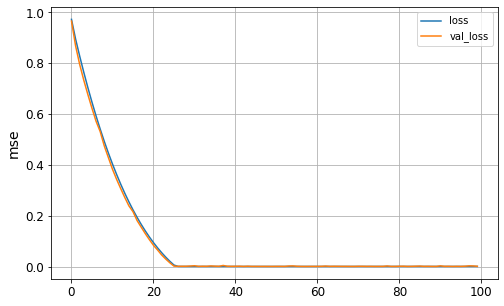

In [ ]:
valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 44 # offset so number of test data points match those of simple model above

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# model architecture with two branches and regularizers

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0', bias_regularizer=L1L2(l1=0.01, l2=0.01))(lstm_input)
x = Dropout(0.4, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(50, name='tech_dense_0',bias_regularizer=L1L2(l1=0.01, l2=0.01))(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.4, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = keras.layers.concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(50, activation="sigmoid", name='dense_pooling',bias_regularizer=L1L2(l1=0.01, l2=0.01))(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and then output a single value
model_multi = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = keras.optimizers.Adam()
model_multi.compile(optimizer=adam, loss='mse')
model_multi.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=50, epochs=100, shuffle=True, validation_split=0.3)

# plot performance of our model based on all three metrics
pd.DataFrame({key: model_multi.history.history[key] for key in ["loss", "val_loss"]}).plot(figsize=(8, 5))   
plt.grid(True)
plt.ylabel("mse")
plt.show()


In [ ]:
# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

Real MSE: 16.103471568964277
Scaled MSE: 0.5063929004916673


As you can see, the multi branch model did a lot better than a simple model, with scaled mse of 0.34 compared to 0.92. This presumable can be improved even further with hyperparameter tuning, or using various other types of neural networks and adding more technical indicators to our model.

In [ ]:
trading_algo(index, y_test)


*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $65.32
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,531.0120 units worth $65.32 each)



Order       Date   Price # of stocks
0   Buy 2019-06-11  $65.32  1,531.0120
1  Sell 2020-03-30  $49.75  3,062.0239
2   Buy 2020-03-31  $50.75  3,001.6885


Total Cash on Hand: $0.00
Total Stock on Hand: $172,597.09 (3,001.6885 units worth $57.50 each)
Total Profit: $-27,402.91 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $88,033.19 (1,531.0120 units worth $57.50 each)
Total Profit: $-11,966.81 over 338 days


and now let's do the same for the rest of the stocks

In [ ]:
#@title KBank
index = 0 # KBANK stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 44

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.fit_transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 31.60228501838362
Scaled MSE: 0.2844356146114619

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $183.76
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (544.1935 units worth $183.76 each)



Order       Date    Price # of stocks
0  Sell 2019-08-07  $159.48    544.1935
1   Buy 2019-08-08  $157.57  1,185.3883
2  Sell 2019-09-12  $161.87  1,185.3883


Total Cash on Hand: $191,881.77
Total Stock on Hand: $0.00 (0.0000 units worth $75.25 each)
Total Profit: $-8,118.23 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $40,950.56 (544.1935 units worth $75.25 each)
Total Profit: $-59,049.44 over 338 days


In [ ]:
#@title SCB
index = 1 # SCB stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 44

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 13.9286890725348
Scaled MSE: 0.20569865503941237

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $122.65
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (815.3239 units worth $122.65 each)



Order       Date    Price # of stocks
0   Sell 2019-06-11  $122.65    815.3239
1    Buy 2019-07-17  $128.69  1,554.1193
2   Sell 2019-08-23  $116.15  1,554.1193
3    Buy 2019-08-26  $114.75  1,572.9952
4   Sell 2019-09-24  $111.95  1,572.9952
5    Buy 2019-09-30  $111.01  1,586.3256
6   Sell 2019-10-29  $102.54  1,586.3256
7    Buy 2019-10-30  $104.89  1,550.7578
8   Sell 2020-02-06   $95.26  1,550.7578
9    Buy 2020-02-07   $95.26  1,550.7578
10  Sell 2020-03-10   $70.38  1,550.7578
11   Buy 2020-03-11   $69.91  1,561.2715
12  Sell 2020-04-01   $64.22  1,561.2715
13   Buy 2020-04-22   $67.00  1,496.4684
14  Sell 2020-06-02   $76.50  1,496.4684
15   Buy 2020-06-22   $71.50  1,601.1165
16  Sell 2020-08-14   $72.25  1,601.1165


Total Cash on Hand: $115,680.67
Total Stock on Hand: $0.00 (0.0000 units worth $66.00 each)
Total Profit: $-84,319.33 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $53,811.38 (815.3239 units worth $66.00 each)
Total Profit: $-46,188.62 over 338 days


In [ ]:
#@title NASDAQ
index = 5 # NASDAQ stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 54

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 24.454994044231338
Scaled MSE: 0.46984226960972203

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $92.73
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,078.3846 units worth $92.73 each)



Order       Date   Price # of stocks
0   Buy 2019-06-21  $96.15  1,039.9946
1  Sell 2020-03-24  $82.34  2,118.3793
2   Buy 2020-03-25  $86.28  2,021.6686


Total Cash on Hand: $0.00
Total Stock on Hand: $252,829.87 (2,021.6686 units worth $125.06 each)
Total Profit: $52,829.87 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $134,862.78 (1,078.3846 units worth $125.06 each)
Total Profit: $34,862.78 over 338 days


In [ ]:
#@title Amazon
index = 7 # Amazon stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 54

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 9740.674149392273
Scaled MSE: 5.134410089518773

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1,863.70
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (53.6567 units worth $1,863.70 each)



Order       Date      Price # of stocks
0   Buy 2019-07-03  $1,939.00     51.5730
1  Sell 2019-08-06  $1,787.83    105.2297
2   Buy 2019-08-07  $1,793.40    104.9029


Total Cash on Hand: $0.00
Total Stock on Hand: $344,778.95 (104.9029 units worth $3,286.65 each)
Total Profit: $144,778.95 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $176,350.81 (53.6567 units worth $3,286.65 each)
Total Profit: $76,350.81 over 338 days


In [ ]:
#@title Google
index = 9 # Google stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 54

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 4157.30492149796
Scaled MSE: 6.410227620699828

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1,078.72
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (92.7025 units worth $1,078.72 each)



Order       Date      Price # of stocks
0   Buy 2019-06-14  $1,085.35     92.1362


Total Cash on Hand: $0.00
Total Stock on Hand: $280,071.20 (184.8386 units worth $1,515.22 each)
Total Profit: $80,071.20 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $140,464.63 (92.7025 units worth $1,515.22 each)
Total Profit: $40,464.63 over 338 days


In [ ]:
#@title Tesla
index = 10 # Tesla stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 54

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 558.5141454515949
Scaled MSE: 1.3585280434658702

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $86.08
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,161.7641 units worth $86.08 each)



Order       Date   Price # of stocks
0  Sell 2019-12-27  $86.08  1,161.7641
1   Buy 2020-01-09  $96.27  2,077.5336


Total Cash on Hand: $0.00
Total Stock on Hand: $901,649.58 (2,077.5336 units worth $434.00 each)
Total Profit: $701,649.58 over 199 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $504,205.61 (1,161.7641 units worth $434.00 each)
Total Profit: $404,205.61 over 199 days


In [ ]:
#@title Johnson & Johnson
index = 11 # JnJ stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

valid_split = int(0.9 * ohlcv_histories_normalised.shape[0]) + 54

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# evaluation
y_test = model_multi.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[valid_split+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

trading_algo(index, y_test)

Real MSE: 36.645981739299266
Scaled MSE: 1.128709078840699

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $134.14
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (745.4950 units worth $134.14 each)



Order       Date    Price # of stocks
0   Buy 2019-06-13  $135.03    740.5676
1  Sell 2019-07-24  $124.54  1,486.0626
2   Buy 2019-07-25  $125.83  1,470.8755


Total Cash on Hand: $0.00
Total Stock on Hand: $220,525.71 (1,470.8755 units worth $149.93 each)
Total Profit: $20,525.71 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $111,770.71 (745.4950 units worth $149.93 each)
Total Profit: $11,770.71 over 338 days


Here's a summary table for all the returns:

>Stock | Normal LSTM MSE | Normal LSTM Returns  | Multi Branch MSE | Multi Branch Returns | Just Holding | Random Buy/Sell
>:--- | ---: | ---: | ---: | ---: | ---: | ---:
>Airport of Thailand | 0.9215 | \$13,095.87 | 0.5064 | \$-27,402.91 | \$-11,966.81 | \$-56,462.30
>Kasikorn Bank | 1.3317 | \$0 | 0.2844 | \$-8,118.23 | \$-59,049.44 | \$-4,207.63
>SCB | 1.1905 | \$0 | 0.2057 | \$-84,319.33 | \$-46,188.62 | \$-75,137.89
>NASDAQ | 1.1095 | \$36,132.98 | 0.4698 | \$52,829.87 | \$34,862.78 | \$-15,833.85 
>Amazon | 16.1857 | \$141,049.39 | 5.1344 | \$144,778.95 | \$76,350.81 | \$66,613.97
>Google | 13.2662 | \$80,929.25 | 6.4102 | \$80,071.20 | \$40,464.63 | \$13,678.32
>Tesla | 6.2295	| \$13,185.50 | 1.3585 | \$701,649.58 | \$404,205.61 | \$180,745.84
>Johnson & Johnson | 1.5706	| \$32,583.71 | 1.1287 | \$20,525.71 | \$11,770.71 | \$-21,226.72
>Total | | \$316,976.70 | | \$880,014.84 | \$450,449.67 | \$88,169.74

As expected, overall, the multi branch with technical indicators performed the best, followed by our normal LSTM model, just holding the stocks, then lastly, random buy/sell. There are some exceptions, such as low returns from Tesla using the simple LSTM model, negative SCB returns using the multi branch model.

The 0's for Kasikorn Bank and SCB under Normal LSTM Returns signal that the stocks were sold for cash immediately on the first day, and never bought again.